Author: Rene Pickhardt

This notebook investigates several things: 

* [Done] how often and far does the max_flow / min_cut diviate from the payment pairs existing incoming and outgoing liquidity 
* [X] Given a twosplit what is the best split ratio? 
* [X] How do various discussed splitting strategies behave?

In [32]:
import json
import networkx as nx
import random
import matplotlib.pyplot as plt

## Setup and data import

In [7]:
def import_channel_graph():
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.Graph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        cap = int(channel["satoshis"])
        G.add_edge(src,dest,cap=cap)
    return G

channel_graph = import_channel_graph()

In [46]:
def create_balanced_graph(channel_graph,p=0):
    """p is the probability that the channel is onsided. Thus the default p=0 creates a uniform distribution"""
    funded_network = nx.DiGraph()
    for src,dest in channel_graph.edges():
        cap = channel_graph[src][dest]["cap"]
        bal = None
        if random.random()>=p:
            bal = random.randint(0,cap)
        else:
            if random.random()>0.5:
                bal=0
            else:
                bal=cap
        funded_network.add_edge(src,dest,cap=cap,capacity=bal)
        funded_network.add_edge(dest,src,cap=cap,capacity=cap-bal)
    return funded_network
    
funded_network = create_balanced_graph(channel_graph,p=0.3)

In [47]:
nodes = set(funded_network.nodes)

## Experiment 1: Max Flow vs payment pairs local view: 

We assume a receiving node will not issue an invoice larger than the amount of satoshis it can theoretically receive. Similarly we assume a sending node will not try to pay an invoice if it does not have enough funds to do so. 

We want to see how ofter the maxflow is actually constrained by these two numbers given

* the actual channelGraph with real capacities
* a uniform distribution of balances (as measured before globally)

In [48]:
def compute_inbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[n][node]["capacity"]
    return res

def compute_outbound(funded_network,node): 
    res = 0
    for n in funded_network.neighbors(node): 
        res += funded_network[node][n]["capacity"]
    return res


In [55]:
def create_samples(n=3600,p=0):
    res1 = []
    for i in range(n):
        payment_pair = random.sample(nodes,2)
        src, dest = payment_pair
        cut_value, partition = nx.minimum_cut(funded_network, src, dest)
        reachable, non_reachable = partition
        outbound = compute_outbound(funded_network,src)
        inbound = compute_inbound(funded_network, dest)
        print(src[:10],dest[:10], cut_value, outbound, inbound)
        lim = min(outbound,inbound)
        if lim==0: 
            res1.append(1.0)
        else:
            res1.append(cut_value/lim)
        if len(res1)%100 ==0:
            print(len(res1))
    return res1

In [ ]:
def create_frequency_timeseries(res):
    # Attention we might have sampled the same payment pair twice!
    f=0
    frequencies = []
    for k,x in enumerate(reversed(res)):
        if x < 1.0:
            f+=1
        frequencies.append(f/(k+1))
    print(f/len(res), f, len(res))
    return frequencies
frequencies_uniform_model = create_frequency_timeseries(create_samples(3600,0))
frequencies_mixed_model = create_frequency_timeseries(create_samples(3600,0.3))

03dd15edf1 0208b5c70e 7081021 21887537 7129434
03db495a7b 0206507b73 91538 91538 1054454
03225e307f 0379ed1af3 40079 40079 680120
02b526c37f 03a4761d92 367208 893904 367208
03c1a8ccc5 021a0266be 893461 42555078 893461
0201fa3ecc 02a02b4987 26596 26596 1505695
033a83907e 0295bd0f3e 198299 11047841 198299
02c10e0f0b 02c197ffa4 569923 569923 60969242
03ee59428b 03c26d296e 0 63216 0
032e3a79dc 021bb42fe0 196126 21873751 196126
0254a73472 02685697ab 1555684 8451150 1555684
03a46347ce 0321146f89 0 347427 0
0333275459 02d21c4174 66623 66623 1366596
037041db9f 037bac010f 65295 163438 65295
03a6680e79 03e1300ab2 531031 5442973 560516
0327e3eed8 03ad6cd751 67914 67914 3674054
025bff93c8 022769c275 187377 187377 387469
03f9ceb115 03594eabc9 238795 2183728 238795
034a1a1c49 02749ad485 28727 2619063 28727
02355a8815 02f9b694a7 65085 65085 515841
03114576a6 02c6c35635 0 37191 0
029bf3edd7 02c4748d7a 5846 9407776 5846
022b8ece90 03e9725720 4257327 5000000 4257327
023c9a852c 024a3af80c 370044 370044 7

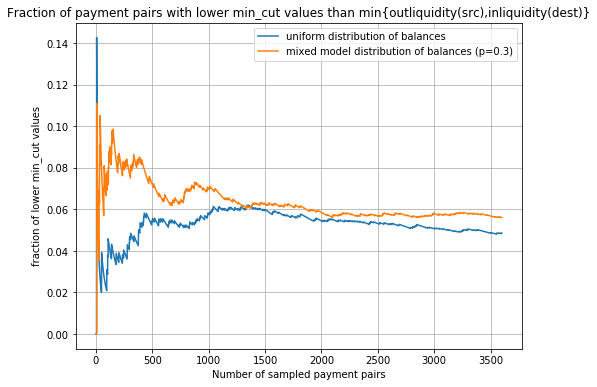

0.05611111111111111 0.04861111111111111


In [58]:
plt.figure(figsize=(8,6))
plt.title("Fraction of payment pairs with lower min_cut values than min{outliquidity(src),inliquidity(dest)}")
plt.plot(frequencies_uniform_model,label="uniform distribution of balances")
plt.plot(frequencies_mixed_model,label="mixed model distribution of balances (p=0.3)")

plt.grid()
plt.xlabel("Number of sampled payment pairs")
plt.ylabel("fraction of lower min_cut values")
plt.legend()
#plt.savefig("../../paper/img/max_flow_fraction.png")
plt.show()

print(f_mixed_model[-1], frequencys[-1])

## Experiment 2: optimal splitting ratio

We want to emperically estimate the expected number of attempts needed for various splitting ratios. This is to test the hypothesis that an equidistant splitting for multipart payments works best

In [28]:
## TODO next

## Experiment 3: various splitting strategies

we want to test at least three splitting strategies

### Proposed greedy strategy: 
* compute the theoretic optimal split
* send out onions
* merge failed onions
* update knowledge of the graph
* repeat with the remaining amount

## c-lightning split
* do 10 attempts
* split in half
* repeat each half 

## Binary splitter
* not clear how to implement